# Co-Simulation

In this example, we simulate a basic energy system of a small datacenter equipped with on-site solar power and a simple battery.

In [1]:
from vessim.actor import ComputingSystem, Generator
from vessim.controller import Monitor
from vessim.cosim import Environment
from vessim.power_meter import MockPowerMeter
from vessim.signal import HistoricalSignal
from vessim.storage import SimpleBattery

# Hotfix to execute asyncio in Jupyter
import nest_asyncio
nest_asyncio.apply()

8e define an `Environment` with a single `Microgird` that comprises

- A simulated `ComputingSystem` with two servers that consistently draw 200W and 250W, respectively. The datacenter has a [power usage effectiveness](https://en.wikipedia.org/wiki/Power_usage_effectiveness) of 1.6, resulting in a total power demand of 1.6 * (200 W + 250 W) = 720 W.
- A `Generator` which represents a solar panel in Berlin, modeled according to the dataset `solcast2022_global` that comes with Vessim (see "Signal" example). The values are normalized to represent the panel's power production potential in percentages. For instance, on July 8th, 2022, in Berlin, the value given is 0.6, meaning that a solar panel would generate 60% of its maximum potential energy.
- A `SimpleBattery` with a usable capacity of 100 Wh which is initially charged with 80Wh.
- A `Monitor` which periodically stores the microgrid state and eventually writes it to a CSV file.

In [2]:
environment = Environment(sim_start="2022-06-09 00:00:00")

monitor = Monitor()  # stores simulation result on each step
environment.add_microgrid(
    actors=[
        ComputingSystem(power_meters=[MockPowerMeter(p=200), MockPowerMeter(p=250)], pue=1.6),
        Generator(
            signal=HistoricalSignal.from_dataset("solcast2022_global", params={"scale": 5000}),
            column="Berlin",
        ),
    ],
    controllers=[monitor],
    storage=SimpleBattery(capacity=100 * 3600, charge_level=80 * 3600),
    step_size=60,  # global step size (can be overridden by actors or controllers)
)

environment.run(until=24 * 3600)  # 24h
monitor.to_csv("result.csv")

2024-04-22 11:32:52.325 | INFO     | mosaik.scenario:start:280 - Starting "Actor" as "Actor-0" ...
2024-04-22 11:32:52.326 | INFO     | mosaik.scenario:start:280 - Starting "Actor" as "Actor-1" ...
2024-04-22 11:32:52.327 | INFO     | mosaik.scenario:start:280 - Starting "Aggregator" as "Aggregator-0" ...
2024-04-22 11:32:52.327 | INFO     | mosaik.scenario:start:280 - Starting "Controller" as "Controller-0" ...
2024-04-22 11:32:52.328 | INFO     | mosaik.scenario:start:280 - Starting "Grid" as "Grid-0" ...
2024-04-22 11:32:52.330 | INFO     | mosaik.scenario:run:598 - Starting simulation.
100%|██████████| 86400/86400 [00:00<00:00, 130816.03steps/s]
2024-04-22 11:32:52.993 | INFO     | mosaik.scenario:run:646 - Simulation finished successfully.


For example, we can observe that at night, when no solar power is produced, the
battery is completely depleted first before drawing power from the grid. Then,
between 6am and 9am $e_{delta}$ stagnates because the solar panels generate more
power than our computing system requires. As a consequence, the battery is
charged first before excess energy is fed back to the grid.

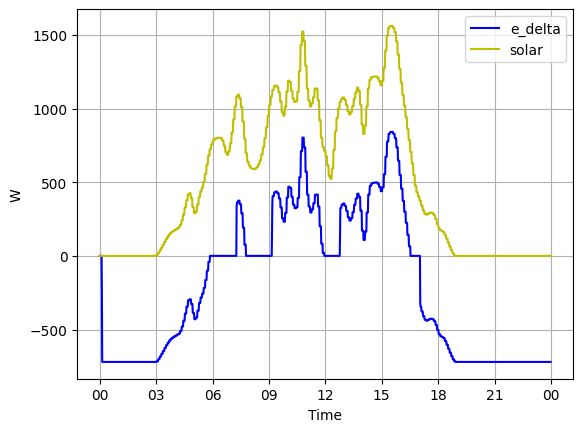

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_csv("result.csv", parse_dates=[0], index_col=0)
# divide e_delta by step size because e_delta is energy
df["e_delta"] = df["e_delta"] / 60

fig, ax1 = plt.subplots()

ax1.plot(df.index, df["e_delta"], color="b", label="e_delta")
ax1.legend()
ax1.plot(df.index, df["actor_states.Generator-0.p"], color="y", label="solar")
ax1.legend()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
ax1.grid()
ax1.set_xlabel("Time")
ax1.set_ylabel("W")

plt.show()